# 🚀 LSTM Optimization - Google Colab GPU Edition

**Systematisches LSTM-Tuning mit GPU-Beschleunigung**

**Setup:**
- Runtime → Change runtime type → GPU (T4 oder A100)
- ~10-50x schneller als CPU!

In [2]:
# Check GPU
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("\n🚀 GPU should show above!")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

🚀 GPU should show above!


In [3]:
# Clone Repository
!git clone https://github.com/chradden/AdvancedTimeSeriesPrediction.git
%cd AdvancedTimeSeriesPrediction/energy-timeseries-project

Cloning into 'AdvancedTimeSeriesPrediction'...
remote: Enumerating objects: 744, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 744 (delta 14), reused 52 (delta 12), pack-reused 682 (from 1)
Receiving objects: 100% (744/744), 72.17 MiB | 30.24 MiB/s, done.
Resolving deltas: 100% (259/259), done.
/content/AdvancedTimeSeriesPrediction/energy-timeseries-project


In [4]:
# Install Dependencies
!pip install -q pandas numpy matplotlib seaborn scikit-learn tensorflow keras

In [5]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

# GPU Config
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU configured: {len(gpus)} device(s)")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU found - training will be slow!")

✅ GPU configured: 1 device(s)


## ⚙️ Configuration - Zeitreihe auswählen

**Ändere hier die Zeitreihe:**
- `'solar'` - Solarenergie-Erzeugung
- `'wind_offshore'` - Offshore-Windenergie  
- `'wind_onshore'` - Onshore-Windenergie
- `'price'` - Strompreise
- `'consumption'` - Energieverbrauch

Oder setze `RUN_ALL_SERIES = True` um alle Zeitreihen nacheinander zu verarbeiten!

In [6]:
# ============================================================================
# CONFIGURATION - ZEITREIHE AUSWÄHLEN
# ============================================================================

# Option 1: Einzelne Zeitreihe (Standard)
SERIES_NAME = 'solar'  # Ändere hier: 'solar', 'wind_offshore', 'wind_onshore', 'price', 'consumption'

# Option 2: Alle Zeitreihen nacheinander verarbeiten
RUN_ALL_SERIES = False  # Setze auf True für Batch-Verarbeitung

# Verfügbare Zeitreihen
AVAILABLE_SERIES = ['solar', 'wind_offshore', 'wind_onshore', 'price', 'consumption']

# Serie(n) bestimmen
if RUN_ALL_SERIES:
    series_to_process = AVAILABLE_SERIES
    print("🔄 MODE: Alle Zeitreihen werden nacheinander verarbeitet")
    print(f"   → {len(series_to_process)} Serien: {', '.join(series_to_process)}")
else:
    series_to_process = [SERIES_NAME]
    print(f"📊 MODE: Einzelne Zeitreihe")
    print(f"   → Serie: {SERIES_NAME}")

print(f"\n✅ Konfiguration abgeschlossen!")

📊 MODE: Einzelne Zeitreihe
   → Serie: solar

✅ Konfiguration abgeschlossen!


In [7]:
# Load processed data for current series
series_name = series_to_process[0] if not RUN_ALL_SERIES else SERIES_NAME

train_df = pd.read_csv(f'data/processed/{series_name}_train.csv')
val_df = pd.read_csv(f'data/processed/{series_name}_val.csv')
test_df = pd.read_csv(f'data/processed/{series_name}_test.csv')

print(f"📂 Loading data for: {series_name.upper()}")
print(f"   Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print(f"   Columns: {train_df.columns.tolist()[:10]}...")

📂 Loading data for: SOLAR
   Train: 21697 | Val: 2232 | Test: 2208
   Columns: ['timestamp', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_weekend', 'is_night', 'hour_sin', 'hour_cos', 'lag_1']...


In [8]:
# Determine value column
value_col = [c for c in train_df.columns if c in ['solar', 'price', 'value',
                                                     'wind_offshore', 'wind_onshore', 'consumption']][0]
feature_cols = [c for c in train_df.columns if c not in ['timestamp', value_col]]

print(f"Value column: {value_col}")
print(f"Features: {len(feature_cols)}")

Value column: solar
Features: 27


## 🔧 Prepare Data

In [9]:
def create_sequences(data, target, seq_length):
    """Create sequences for LSTM"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

# Scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(train_df[feature_cols])
y_train = scaler_y.fit_transform(train_df[[value_col]])

X_val = scaler_X.transform(val_df[feature_cols])
y_val = scaler_y.transform(val_df[[value_col]])

X_test = scaler_X.transform(test_df[feature_cols])
y_test_orig = test_df[value_col].values

print(f"✅ Data scaled: X_train shape = {X_train.shape}")

✅ Data scaled: X_train shape = (21697, 27)


## 🧪 Experiment 1: Baseline LSTM

In [10]:
seq_length = 24

X_train_seq, y_train_seq = create_sequences(X_train, y_train.flatten(), seq_length)
X_val_seq, y_val_seq = create_sequences(X_val, y_val.flatten(), seq_length)
X_test_seq, _ = create_sequences(X_test, np.zeros(len(X_test)), seq_length)
y_test_seq = y_test_orig[seq_length:]

print(f"Sequences: Train={X_train_seq.shape}, Val={X_val_seq.shape}, Test={X_test_seq.shape}")

Sequences: Train=(21673, 24, 27), Val=(2208, 24, 27), Test=(2184, 24, 27)


In [11]:
# Build Baseline LSTM
model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(seq_length, X_train.shape[1])),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        23,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,057 (144.75 KB)

 Trainable params: 37,057 (144.75 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

start = time.time()
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
train_time = time.time() - start

print(f"\n✅ Training completed in {train_time:.1f}s ({train_time/60:.1f} min)")

Epoch 1/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.2152 - mae: 0.2876 - val_loss: 0.0361 - val_mae: 0.1239 - learning_rate: 0.0010
Epoch 2/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0282 - mae: 0.1139 - val_loss: 0.0229 - val_mae: 0.0957 - learning_rate: 0.0010
Epoch 3/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0175 - mae: 0.0891 - val_loss: 0.0277 - val_mae: 0.1052 - learning_rate: 0.0010
Epoch 4/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0138 - mae: 0.0772 - val_loss: 0.0141 - val_mae: 0.0721 - learning_rate: 0.0010
Epoch 5/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0112 - mae: 0.0681 - val_loss: 0.0171 - val_mae: 0.0842 - learning_rate: 0.0010
Epoch 6/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0095 - mae: 0.0609 - val_loss: 0.0104 - val_mae: 0.0626 - learning_rate: 0.0010
Epoch 7/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0087 - mae: 0.0568 - val_loss: 0.0180 - val_mae: 0.0796 - learning_rate: 0.0010
Epoch 

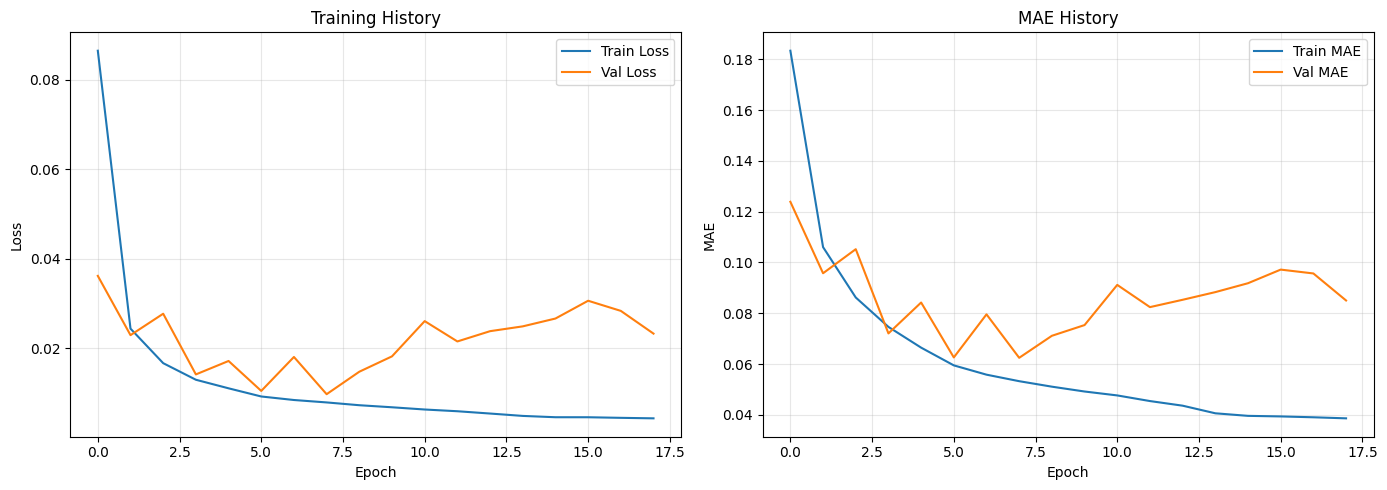

In [13]:
# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training History')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE History')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# Evaluate
y_pred_scaled = model.predict(X_test_seq).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
mae = mean_absolute_error(y_test_seq, y_pred)
r2 = r2_score(y_test_seq, y_pred)

print(f"\n📊 BASELINE LSTM RESULTS:")
print(f"   R² = {r2:.4f}")
print(f"   RMSE = {rmse:.2f}")
print(f"   MAE = {mae:.2f}")

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

📊 BASELINE LSTM RESULTS:
   R² = 0.9934
   RMSE = 424.75
   MAE = 262.73


## 🚀 Experiment 2: Bi-LSTM

In [15]:
# Build Bi-LSTM
model_bilstm = keras.Sequential([
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(seq_length, X_train.shape[1])),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model_bilstm.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_bilstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 24, 128)        │        47,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,433 (353.25 KB)

 Trainable params: 90,433 (353.25 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train Bi-LSTM
start = time.time()
history_bilstm = model_bilstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
train_time_bilstm = time.time() - start

print(f"\n✅ Bi-LSTM training completed in {train_time_bilstm:.1f}s ({train_time_bilstm/60:.1f} min)")

Epoch 1/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.1400 - mae: 0.2167 - val_loss: 0.0150 - val_mae: 0.0897 - learning_rate: 0.0010
Epoch 2/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0156 - mae: 0.0873 - val_loss: 0.0080 - val_mae: 0.0648 - learning_rate: 0.0010
Epoch 3/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0113 - mae: 0.0734 - val_loss: 0.0116 - val_mae: 0.0843 - learning_rate: 0.0010
Epoch 4/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0098 - mae: 0.0673 - val_loss: 0.0066 - val_mae: 0.0578 - learning_rate: 0.0010
Epoch 5/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0084 - mae: 0.0621 - val_loss: 0.0069 - val_mae: 0.0588 - learning_rate: 0.0010
Epoch 6/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0075 - mae: 0.0586 - val_loss: 0.0063 - val_mae: 0.0573 - learning_rate: 0.0010
Epoch 7/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0068 - mae: 0.0550 - val_loss: 0.0055 - val_mae: 0.0515 - learning_rate: 0.0010

In [17]:
# Evaluate Bi-LSTM
y_pred_bilstm_scaled = model_bilstm.predict(X_test_seq).flatten()
y_pred_bilstm = scaler_y.inverse_transform(y_pred_bilstm_scaled.reshape(-1, 1)).flatten()

rmse_bilstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_bilstm))
mae_bilstm = mean_absolute_error(y_test_seq, y_pred_bilstm)
r2_bilstm = r2_score(y_test_seq, y_pred_bilstm)

print(f"\n📊 BI-LSTM RESULTS:")
print(f"   R² = {r2_bilstm:.4f}")
print(f"   RMSE = {rmse_bilstm:.2f}")
print(f"   MAE = {mae_bilstm:.2f}")
print(f"\n🎯 Improvement: {((r2_bilstm - r2) / abs(r2)) * 100:+.2f}% R²")

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

📊 BI-LSTM RESULTS:
   R² = 0.9955
   RMSE = 348.83
   MAE = 197.96

🎯 Improvement: +0.22% R²


## 📊 Comparison

In [18]:
# Results DataFrame
results = pd.DataFrame([
    {'Model': 'LSTM', 'R²': r2, 'RMSE': rmse, 'MAE': mae, 'Time': train_time},
    {'Model': 'Bi-LSTM', 'R²': r2_bilstm, 'RMSE': rmse_bilstm, 'MAE': mae_bilstm, 'Time': train_time_bilstm}
])

print("\n🏆 COMPARISON:")
print(results.to_string(index=False))

# Save
results.to_csv(f'results/metrics/lstm_colab_{series_name}.csv', index=False)
print(f"\n✅ Results saved to: results/metrics/lstm_colab_{series_name}.csv")


🏆 COMPARISON:
  Model       R²       RMSE        MAE       Time
   LSTM 0.993357 424.746802 262.734675  49.057940
Bi-LSTM 0.995519 348.831182 197.960745 107.570256

✅ Results saved to: results/metrics/lstm_colab_solar.csv


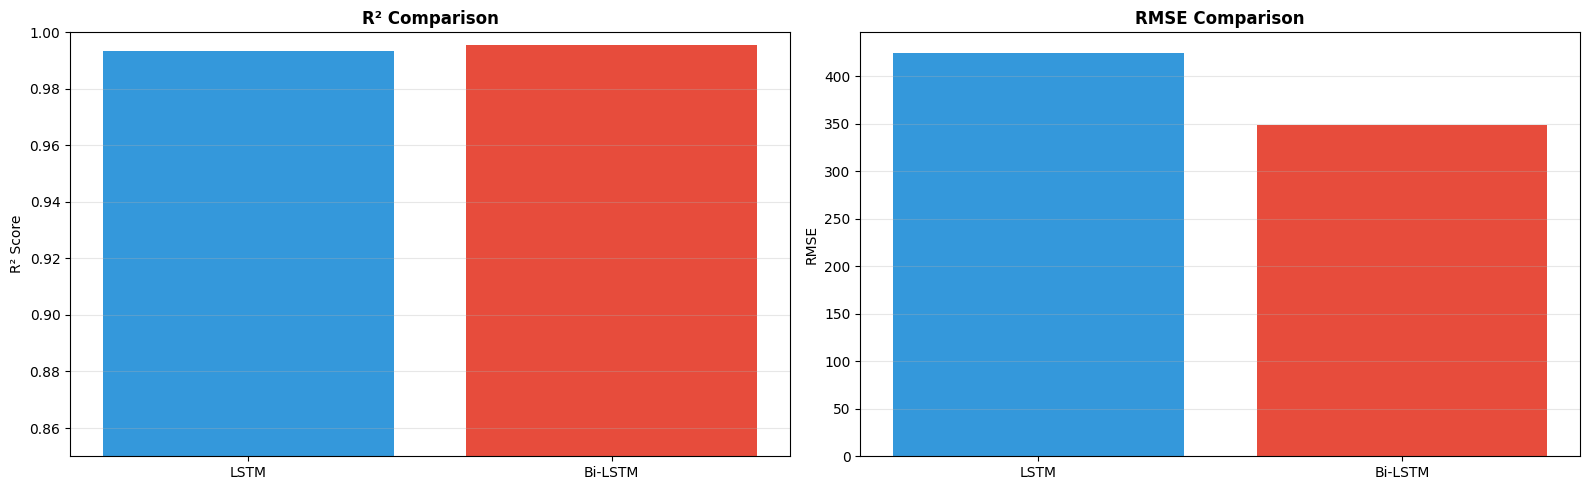

✅ Plot saved to: results/figures/lstm_colab_comparison_solar.png


In [19]:
# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# R² Comparison
axes[0].bar(results['Model'], results['R²'], color=['#3498db', '#e74c3c'])
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Comparison', fontweight='bold')
axes[0].set_ylim([0.85, 1.0])
axes[0].grid(alpha=0.3, axis='y')

# RMSE Comparison
axes[1].bar(results['Model'], results['RMSE'], color=['#3498db', '#e74c3c'])
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE Comparison', fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'results/figures/lstm_colab_comparison_{series_name}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved to: results/figures/lstm_colab_comparison_{series_name}.png")

## 💾 Save Best Model

In [20]:
import os

# Save best model
best_model = model_bilstm if r2_bilstm > r2 else model
best_name = 'Bi-LSTM' if r2_bilstm > r2 else 'LSTM'

# Create the models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

best_model.save(f'models/lstm_best_{series_name}.keras')
print(f"✅ Best model ({best_name}) saved to: models/lstm_best_{series_name}.keras")

✅ Best model (Bi-LSTM) saved to: models/lstm_best_solar.keras


## 🎨 Experiment 3: Generative Models

### Autoencoder für Time Series Forecasting
Autoencoders lernen kompakte Repräsentationen und können Anomalien erkennen.

## 🎯 Summary

**GPU Speedup Check:**
- If you see ~10-50x faster training vs CPU, GPU is working!
- Expected on CPU: ~100-200s per epoch
- Expected on GPU: ~2-5s per epoch

**Next Steps:**
1. Try longer sequences (48h, 168h)
2. Experiment with more units (128, 256)
3. Add Attention mechanism
4. Test on other time series (price, wind_offshore)

In [21]:
# Build LSTM Autoencoder
latent_dim = 16

# Encoder
encoder_inputs = keras.Input(shape=(seq_length, X_train.shape[1]))
x = layers.LSTM(64, return_sequences=True)(encoder_inputs)
x = layers.LSTM(32, return_sequences=False)(x)
encoder_outputs = layers.Dense(latent_dim, activation='relu')(x)

# Decoder
decoder_inputs = layers.RepeatVector(seq_length)(encoder_outputs)
x = layers.LSTM(32, return_sequences=True)(decoder_inputs)
x = layers.LSTM(64, return_sequences=True)(x)
decoder_outputs = layers.TimeDistributed(layers.Dense(X_train.shape[1]))(x)

# Autoencoder
autoencoder = keras.Model(encoder_inputs, decoder_outputs, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mse')

print("🔧 Autoencoder Architecture:")
autoencoder.summary()

🔧 Autoencoder Architecture:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 24, 27)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 24, 64)         │        23,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 24, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 24, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 24, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 24, 27)         │         1,755 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,355 (270.92 KB)

 Trainable params: 69,355 (270.92 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train Autoencoder
start = time.time()
history_ae = autoencoder.fit(
    X_train_seq, X_train_seq,  # Reconstruct input
    validation_data=(X_val_seq, X_val_seq),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)
train_time_ae = time.time() - start
print(f"\n✅ Autoencoder training completed in {train_time_ae:.1f}s")

Epoch 1/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.5599 - val_loss: 0.2055
Epoch 2/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1089 - val_loss: 0.1181
Epoch 3/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0633 - val_loss: 0.0890
Epoch 4/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0457 - val_loss: 0.0717
Epoch 5/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0369 - val_loss: 0.0647
Epoch 6/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0317 - val_loss: 0.0587
Epoch 7/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0281 - val_loss: 0.0531
Epoch 8/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0255 - val_loss: 0.0464
Epoch 9/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0229 - val_loss: 0.0412
Epoch 10/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0208 - val_loss: 0.0383
Epoch 11/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0193 - val_loss: 0.0363
Epoch 12/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 

In [23]:
# Build forecasting model on top of encoder
encoder_model = keras.Model(encoder_inputs, encoder_outputs, name='encoder')

# Freeze encoder
for layer in encoder_model.layers:
    layer.trainable = False

# Add forecasting head
forecast_inputs = keras.Input(shape=(seq_length, X_train.shape[1]))
encoded = encoder_model(forecast_inputs)
x = layers.Dense(32, activation='relu')(encoded)
x = layers.Dropout(0.2)(x)
forecast_output = layers.Dense(1)(x)

model_ae_forecast = keras.Model(forecast_inputs, forecast_output, name='ae_forecast')
model_ae_forecast.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("🔧 AE-Forecast Model:")
model_ae_forecast.summary()

🔧 AE-Forecast Model:


Model: "ae_forecast"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 24, 27)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 16)             │        36,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,073 (144.82 KB)

 Trainable params: 577 (2.25 KB)

 Non-trainable params: 36,496 (142.56 KB)

In [24]:
# Train forecasting model
start = time.time()
history_ae_forecast = model_ae_forecast.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
train_time_ae_forecast = time.time() - start

# Evaluate
y_pred_ae_scaled = model_ae_forecast.predict(X_test_seq).flatten()
y_pred_ae = scaler_y.inverse_transform(y_pred_ae_scaled.reshape(-1, 1)).flatten()

rmse_ae = np.sqrt(mean_squared_error(y_test_seq, y_pred_ae))
mae_ae = mean_absolute_error(y_test_seq, y_pred_ae)
r2_ae = r2_score(y_test_seq, y_pred_ae)

print(f"\n📊 AUTOENCODER-FORECAST RESULTS:")
print(f"   R² = {r2_ae:.4f}")
print(f"   RMSE = {rmse_ae:.2f}")
print(f"   MAE = {mae_ae:.2f}")
print(f"   Time = {train_time_ae_forecast:.1f}s")

Epoch 1/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0186 - mae: 0.7562 - val_loss: 0.3768 - val_mae: 0.4405 - learning_rate: 0.0010
Epoch 2/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2483 - mae: 0.3687 - val_loss: 0.2340 - val_mae: 0.3301 - learning_rate: 0.0010
Epoch 3/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1676 - mae: 0.2840 - val_loss: 0.1679 - val_mae: 0.2754 - learning_rate: 0.0010
Epoch 4/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1393 - mae: 0.2531 - val_loss: 0.1360 - val_mae: 0.2506 - learning_rate: 0.0010
Epoch 5/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1184 - mae: 0.2329 - val_loss: 0.1208 - val_mae: 0.2353 - learning_rate: 0.0010
Epoch 6/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1101 - mae: 0.2232 - val_loss: 0.1156 - val_mae: 0.2262 - learning_rate: 0.0010
Epoch 7/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1064 - mae: 0.2158 - val_loss: 0.1119 - val_mae: 0.2215 - learning_rate: 0.0010
Epoch 

### VAE (Variational Autoencoder)
VAE lernt probabilistische latente Repräsentationen - nützlich für Unsicherheitsquantifizierung.

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Sampling layer for VAE
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# VAE Encoder
vae_inputs = keras.Input(shape=(seq_length, X_train.shape[1]))
x = layers.LSTM(64, return_sequences=True)(vae_inputs)
x = layers.LSTM(32)(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

vae_encoder = keras.Model(vae_inputs, [z_mean, z_log_var, z], name='vae_encoder')

# VAE Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.RepeatVector(seq_length)(latent_inputs)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)
vae_outputs = layers.TimeDistributed(layers.Dense(X_train.shape[1]))(x)

vae_decoder = keras.Model(latent_inputs, vae_outputs, name='vae_decoder')

# VAE full model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # Unpack the data tuple: data = (x, y) if called with fit(x, y)
        # For autoencoders, x is the input and also the target for reconstruction.
        x = data[0] if isinstance(data, tuple) else data # Extract the input part

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x) # Pass only x to the encoder
            reconstruction = self.decoder(z)
            # Corrected reconstruction loss calculation
            reconstruction_error = tf.square(x - reconstruction) # Element-wise squared error
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    reconstruction_error,
                    axis=[1, 2] # Sum over sequence length and features for each batch item
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

vae = VAE(vae_encoder, vae_decoder)
vae.compile(optimizer='adam')

print("🔧 VAE built successfully!")

🔧 VAE built successfully!


In [34]:
# Train VAE
start = time.time()
history_vae = vae.fit(
    X_train_seq, X_train_seq,
    epochs=30,
    batch_size=64,
    verbose=1
)
train_time_vae = time.time() - start
print(f"\n✅ VAE training completed in {train_time_vae:.1f}s")

# Build forecasting model on VAE encoder
vae_encoder_mean = keras.Model(vae_inputs, z_mean, name='vae_encoder_mean')

for layer in vae_encoder_mean.layers:
    layer.trainable = False

forecast_inputs_vae = keras.Input(shape=(seq_length, X_train.shape[1]))
encoded_vae = vae_encoder_mean(forecast_inputs_vae)
x = layers.Dense(32, activation='relu')(encoded_vae)
x = layers.Dropout(0.2)(x)
forecast_output_vae = layers.Dense(1)(x)

model_vae_forecast = keras.Model(forecast_inputs_vae, forecast_output_vae, name='vae_forecast')
model_vae_forecast.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
start = time.time()
history_vae_forecast = model_vae_forecast.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
train_time_vae_forecast = time.time() - start

# Evaluate
y_pred_vae_scaled = model_vae_forecast.predict(X_test_seq).flatten()
y_pred_vae = scaler_y.inverse_transform(y_pred_vae_scaled.reshape(-1, 1)).flatten()

rmse_vae = np.sqrt(mean_squared_error(y_test_seq, y_pred_vae))
mae_vae = mean_absolute_error(y_test_seq, y_pred_vae)
r2_vae = r2_score(y_test_seq, y_pred_vae)

print(f"\n☕ VAE-FORECAST RESULTS:")
print(f"   R² = {r2_vae:.4f}")
print(f"   RMSE = {rmse_vae:.2f}")
print(f"   MAE = {mae_vae:.2f}")
print(f"   Time = {train_time_vae_forecast:.1f}s")

Epoch 1/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - kl_loss: 7.7983 - loss: 487.1698 - reconstruction_loss: 479.3715
Epoch 2/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - kl_loss: 22.8166 - loss: 146.2923 - reconstruction_loss: 123.4757
Epoch 3/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - kl_loss: 23.5762 - loss: 106.1251 - reconstruction_loss: 82.5490
Epoch 4/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - kl_loss: 23.5819 - loss: 83.6609 - reconstruction_loss: 60.0791
Epoch 5/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - kl_loss: 22.9782 - loss: 72.3501 - reconstruction_loss: 49.3720
Epoch 6/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - kl_loss: 22.4783 - loss: 63.2636 - reconstruction_loss: 40.7852
Epoch 7/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - kl_loss: 21.9133 - loss: 56.6131 - reconstruction_loss: 34.6998
Epoch 8/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - kl_loss: 21.5488 - loss: 52.5799 - reconstruction_loss: 31.0311
Epoch 9/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 1

## ⚡ Experiment 4: Advanced Deep Learning Models

### N-BEATS (Neural Basis Expansion Analysis for Time Series)
State-of-the-art für univariate Zeitreihen - speziell designed für Forecasting!

In [35]:
# Install Darts (for N-BEATS, N-HiTS)
!pip install -q darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 72.2 MB/s eta 0:00:00


In [36]:
# Import Darts
from darts import TimeSeries
from darts.models import NBEATSModel, NHiTSModel
from darts.dataprocessing.transformers import Scaler

print("✅ Darts imported successfully!")

✅ Darts imported successfully!


In [37]:
# Prepare data for Darts
train_df_ts = train_df.copy()
train_df_ts['timestamp'] = pd.to_datetime(train_df_ts['timestamp'])
train_df_ts = train_df_ts.set_index('timestamp')

val_df_ts = val_df.copy()
val_df_ts['timestamp'] = pd.to_datetime(val_df_ts['timestamp'])
val_df_ts = val_df_ts.set_index('timestamp')

test_df_ts = test_df.copy()
test_df_ts['timestamp'] = pd.to_datetime(test_df_ts['timestamp'])
test_df_ts = test_df_ts.set_index('timestamp')

# Create TimeSeries objects
ts_train = TimeSeries.from_dataframe(train_df_ts, value_cols=value_col, freq='H')
ts_val = TimeSeries.from_dataframe(val_df_ts, value_cols=value_col, freq='H')
ts_test = TimeSeries.from_dataframe(test_df_ts, value_cols=value_col, freq='H')

# Scale
scaler_darts = Scaler()
ts_train_scaled = scaler_darts.fit_transform(ts_train)
ts_val_scaled = scaler_darts.transform(ts_val)
ts_test_scaled = scaler_darts.transform(ts_test)

print(f"✅ Darts TimeSeries created: {len(ts_train)} train samples")

✅ Darts TimeSeries created: 21697 train samples


/usr/local/lib/python3.12/dist-packages/darts/timeseries.py:5146: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_times = resampled_times.asfreq(freq)
/usr/local/lib/python3.12/dist-packages/darts/timeseries.py:5146: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_times = resampled_times.asfreq(freq)
/usr/local/lib/python3.12/dist-packages/darts/timeseries.py:5146: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_times = resampled_times.asfreq(freq)


In [38]:
# Build N-BEATS model
model_nbeats = NBEATSModel(
    input_chunk_length=168,  # 1 week lookback
    output_chunk_length=24,  # 1 day forecast
    num_stacks=30,
    num_blocks=1,
    num_layers=4,
    layer_widths=256,
    expansion_coefficient_dim=5,
    n_epochs=50,
    batch_size=64,
    optimizer_kwargs={'lr': 1e-3},
    pl_trainer_kwargs={
        'accelerator': 'gpu',
        'devices': 1,
        'enable_progress_bar': True,
    },
    model_name='nbeats_solar',
    force_reset=True,
    save_checkpoints=True
)

print("🔧 N-BEATS model configured!")

🔧 N-BEATS model configured!


In [39]:
# Train N-BEATS
print("🚀 Training N-BEATS (this will be FAST on GPU!)...")
start = time.time()

model_nbeats.fit(
    series=ts_train_scaled,
    val_series=ts_val_scaled,
    verbose=True
)

train_time_nbeats = time.time() - start
print(f"\n✅ N-BEATS training completed in {train_time_nbeats:.1f}s ({train_time_nbeats/60:.1f} min)")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tenso

🚀 Training N-BEATS (this will be FAST on GPU!)...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.3 M  | train
-------------------------------------------------------------
7.3 M     Trainable params
2.3 K     Non-trainable params
7.3 M     Total params
29.323    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.



✅ N-BEATS training completed in 976.9s (16.3 min)


In [40]:
# Predict with N-BEATS
n_pred = len(ts_test)
pred_nbeats_scaled = model_nbeats.predict(n=n_pred, series=ts_train_scaled)
pred_nbeats = scaler_darts.inverse_transform(pred_nbeats_scaled)

# Extract values
y_pred_nbeats = pred_nbeats.values().flatten()
y_test_nbeats = ts_test.values().flatten()

# Ensure same length
min_len = min(len(y_pred_nbeats), len(y_test_nbeats))
y_pred_nbeats = y_pred_nbeats[:min_len]
y_test_nbeats = y_test_nbeats[:min_len]

# Evaluate
rmse_nbeats = np.sqrt(mean_squared_error(y_test_nbeats, y_pred_nbeats))
mae_nbeats = mean_absolute_error(y_test_nbeats, y_pred_nbeats)
r2_nbeats = r2_score(y_test_nbeats, y_pred_nbeats)

print(f"\n📊 N-BEATS RESULTS:")
print(f"   R² = {r2_nbeats:.4f}")
print(f"   RMSE = {rmse_nbeats:.2f}")
print(f"   MAE = {mae_nbeats:.2f}")
print(f"   Time = {train_time_nbeats:.1f}s")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


📊 N-BEATS RESULTS:
   R² = -18.9317
   RMSE = 23316.00
   MAE = 16347.93
   Time = 976.9s


### N-HiTS (Neural Hierarchical Interpolation for Time Series)
Verbesserte Version von N-BEATS - noch besser für lange Horizonte!

In [41]:
# Build N-HiTS model
model_nhits = NHiTSModel(
    input_chunk_length=168,  # 1 week lookback
    output_chunk_length=24,  # 1 day forecast
    num_stacks=3,
    num_blocks=1,
    num_layers=2,
    layer_widths=512,
    n_epochs=50,
    batch_size=64,
    optimizer_kwargs={'lr': 1e-3},
    pl_trainer_kwargs={
        'accelerator': 'gpu',
        'devices': 1,
        'enable_progress_bar': True,
    },
    model_name='nhits_solar',
    force_reset=True,
    save_checkpoints=True
)

print("🔧 N-HiTS model configured!")

🔧 N-HiTS model configured!


In [42]:
# Train N-HiTS
print("🚀 Training N-HiTS...")
start = time.time()

model_nhits.fit(
    series=ts_train_scaled,
    val_series=ts_val_scaled,
    verbose=True
)

train_time_nhits = time.time() - start
print(f"\n✅ N-HiTS training completed in {train_time_nhits:.1f}s ({train_time_nhits/60:.1f} min)")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.0 M  | train
-------------------------------------------------------------
939 K     Trainable params
86.2 K    Non-trainable params
1.0 M     Total params
4.103     Total estimated m

🚀 Training N-HiTS...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.



✅ N-HiTS training completed in 137.7s (2.3 min)


In [43]:
# Predict with N-HiTS
pred_nhits_scaled = model_nhits.predict(n=n_pred, series=ts_train_scaled)
pred_nhits = scaler_darts.inverse_transform(pred_nhits_scaled)

# Extract values
y_pred_nhits = pred_nhits.values().flatten()
y_test_nhits = ts_test.values().flatten()

# Ensure same length
min_len = min(len(y_pred_nhits), len(y_test_nhits))
y_pred_nhits = y_pred_nhits[:min_len]
y_test_nhits = y_test_nhits[:min_len]

# Evaluate
rmse_nhits = np.sqrt(mean_squared_error(y_test_nhits, y_pred_nhits))
mae_nhits = mean_absolute_error(y_test_nhits, y_pred_nhits)
r2_nhits = r2_score(y_test_nhits, y_pred_nhits)

print(f"\n📊 N-HiTS RESULTS:")
print(f"   R² = {r2_nhits:.4f}")
print(f"   RMSE = {rmse_nhits:.2f}")
print(f"   MAE = {mae_nhits:.2f}")
print(f"   Time = {train_time_nhits:.1f}s")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


📊 N-HiTS RESULTS:
   R² = -4.2184
   RMSE = 11930.24
   MAE = 8210.88
   Time = 137.7s


## 📊 Final Comparison - All Models

In [44]:
# Comprehensive results
all_results = pd.DataFrame([
    {'Model': 'LSTM', 'Category': 'Basic DL', 'R²': r2, 'RMSE': rmse, 'MAE': mae, 'Time': train_time},
    {'Model': 'Bi-LSTM', 'Category': 'Basic DL', 'R²': r2_bilstm, 'RMSE': rmse_bilstm, 'MAE': mae_bilstm, 'Time': train_time_bilstm},
    {'Model': 'Autoencoder', 'Category': 'Generative', 'R²': r2_ae, 'RMSE': rmse_ae, 'MAE': mae_ae, 'Time': train_time_ae_forecast},
    {'Model': 'VAE', 'Category': 'Generative', 'R²': r2_vae, 'RMSE': rmse_vae, 'MAE': mae_vae, 'Time': train_time_vae_forecast},
    {'Model': 'N-BEATS', 'Category': 'Advanced', 'R²': r2_nbeats, 'RMSE': rmse_nbeats, 'MAE': mae_nbeats, 'Time': train_time_nbeats},
    {'Model': 'N-HiTS', 'Category': 'Advanced', 'R²': r2_nhits, 'RMSE': rmse_nhits, 'MAE': mae_nhits, 'Time': train_time_nhits}
])

# Sort by R²
all_results = all_results.sort_values('R²', ascending=False)

print("\n" + "="*80)
print("🏆 COMPREHENSIVE MODEL COMPARISON")
print("="*80)
print("\n" + all_results.to_string(index=False))

# Identify best
best = all_results.iloc[0]
print(f"\n🥇 BEST MODEL: {best['Model']} ({best['Category']})")
print(f"   R² = {best['R²']:.4f}")
print(f"   RMSE = {best['RMSE']:.2f}")
print(f"   MAE = {best['MAE']:.2f}")
print(f"   Training Time = {best['Time']:.1f}s")

# Save results
all_results.to_csv(f'results/metrics/deep_learning_comprehensive_{series_name}.csv', index=False)
print(f"\n✅ Results saved to: results/metrics/deep_learning_comprehensive_{series_name}.csv")


🏆 COMPREHENSIVE MODEL COMPARISON

      Model   Category         R²         RMSE          MAE       Time
    Bi-LSTM   Basic DL   0.995519   348.831182   197.960745 107.570256
       LSTM   Basic DL   0.993357   424.746802   262.734675  49.057940
Autoencoder Generative   0.951537  1147.206955   699.000754  78.885550
        VAE Generative   0.925495  1422.423106   898.832920  79.073050
     N-HiTS   Advanced  -4.218360 11930.241388  8210.878593 137.653877
    N-BEATS   Advanced -18.931675 23316.004291 16347.930664 976.866027

🥇 BEST MODEL: Bi-LSTM (Basic DL)
   R² = 0.9955
   RMSE = 348.83
   MAE = 197.96
   Training Time = 107.6s

✅ Results saved to: results/metrics/deep_learning_comprehensive_solar.csv


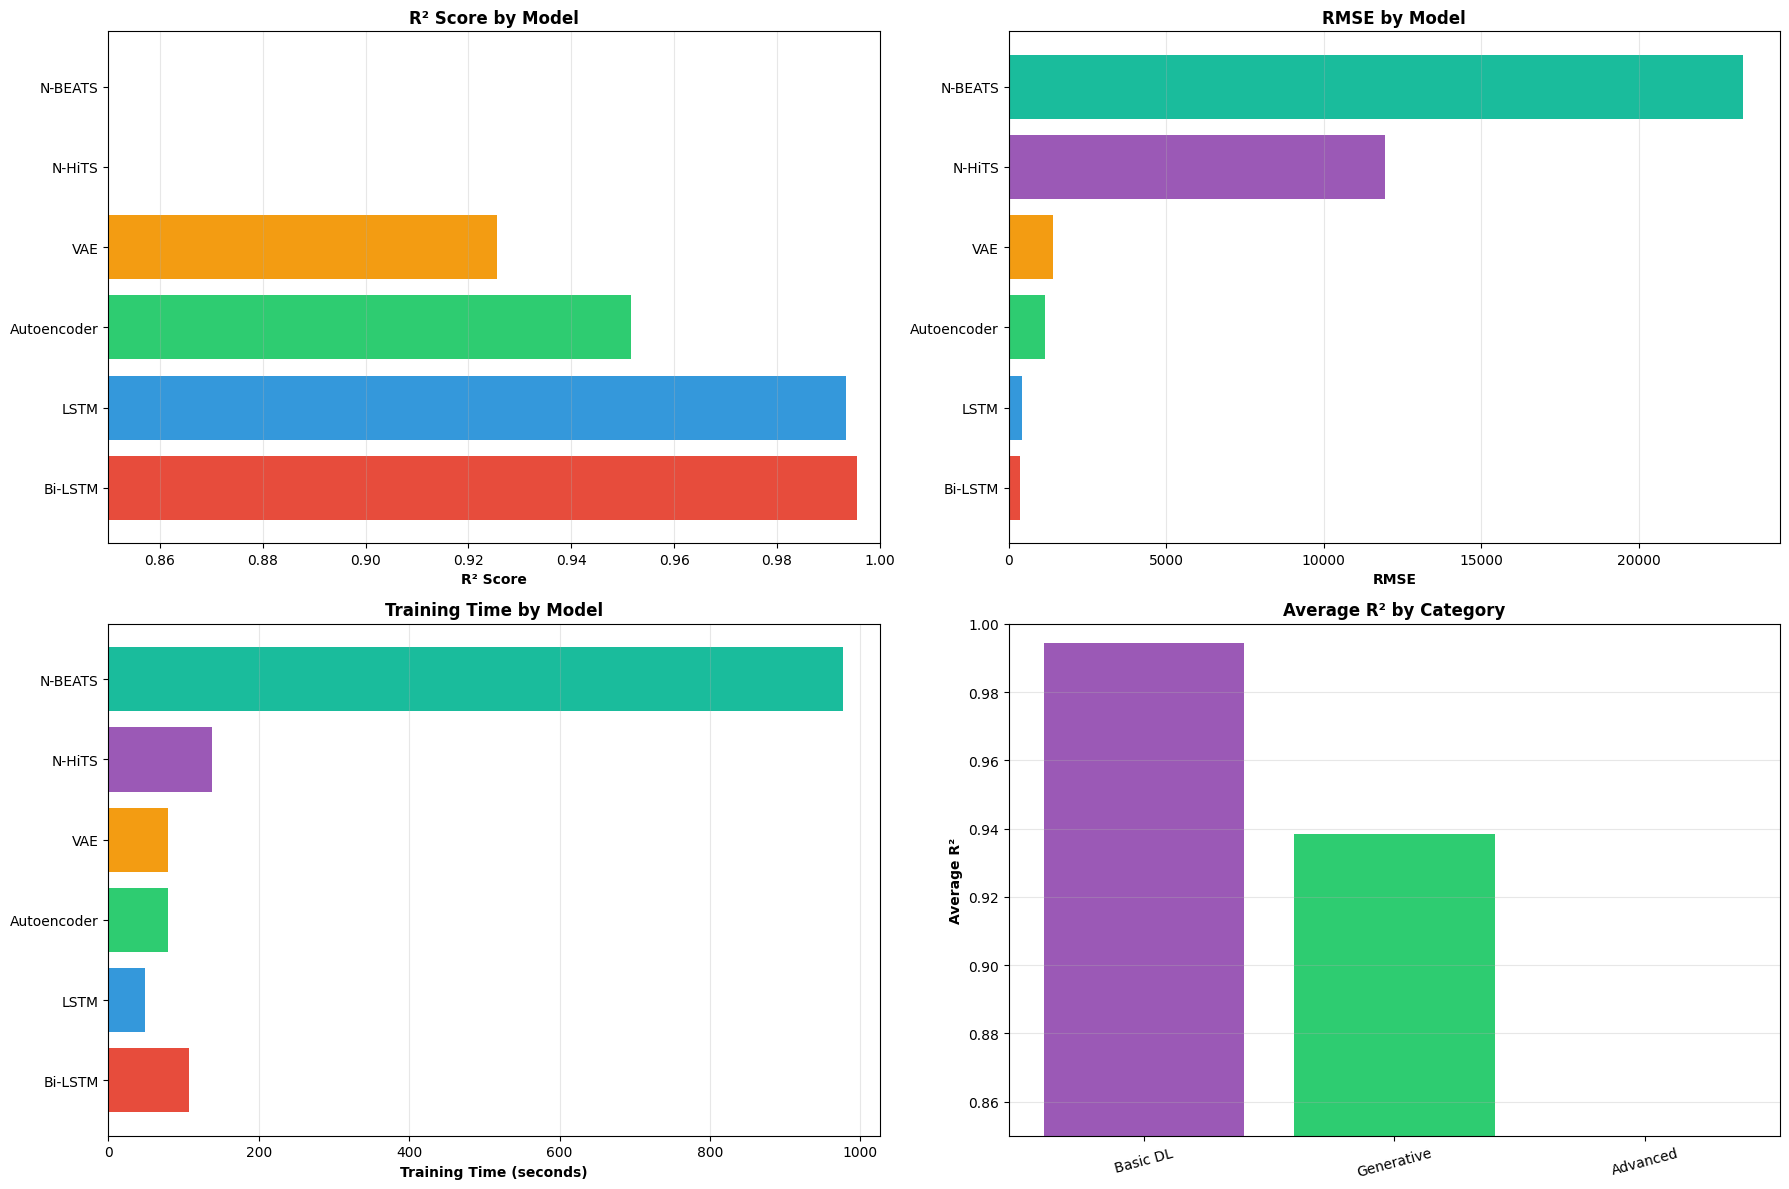

✅ Comprehensive plot saved to: results/figures/deep_learning_comprehensive_solar.png


In [45]:
# Comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# R² by Model
axes[0, 0].barh(all_results['Model'], all_results['R²'],
                color=['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c'])
axes[0, 0].set_xlabel('R² Score', fontweight='bold')
axes[0, 0].set_title('R² Score by Model', fontweight='bold', fontsize=12)
axes[0, 0].set_xlim([0.85, 1.0])
axes[0, 0].grid(alpha=0.3, axis='x')

# RMSE by Model
axes[0, 1].barh(all_results['Model'], all_results['RMSE'],
                color=['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c'])
axes[0, 1].set_xlabel('RMSE', fontweight='bold')
axes[0, 1].set_title('RMSE by Model', fontweight='bold', fontsize=12)
axes[0, 1].grid(alpha=0.3, axis='x')

# Training Time by Model
axes[1, 0].barh(all_results['Model'], all_results['Time'],
                color=['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c'])
axes[1, 0].set_xlabel('Training Time (seconds)', fontweight='bold')
axes[1, 0].set_title('Training Time by Model', fontweight='bold', fontsize=12)
axes[1, 0].grid(alpha=0.3, axis='x')

# R² by Category
category_r2 = all_results.groupby('Category')['R²'].mean().sort_values(ascending=False)
axes[1, 1].bar(category_r2.index, category_r2.values,
               color=['#9b59b6', '#2ecc71', '#3498db'])
axes[1, 1].set_ylabel('Average R²', fontweight='bold')
axes[1, 1].set_title('Average R² by Category', fontweight='bold', fontsize=12)
axes[1, 1].set_ylim([0.85, 1.0])
axes[1, 1].grid(alpha=0.3, axis='y')
axes[1, 1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig(f'results/figures/deep_learning_comprehensive_{series_name}.png',
            dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Comprehensive plot saved to: results/figures/deep_learning_comprehensive_{series_name}.png")

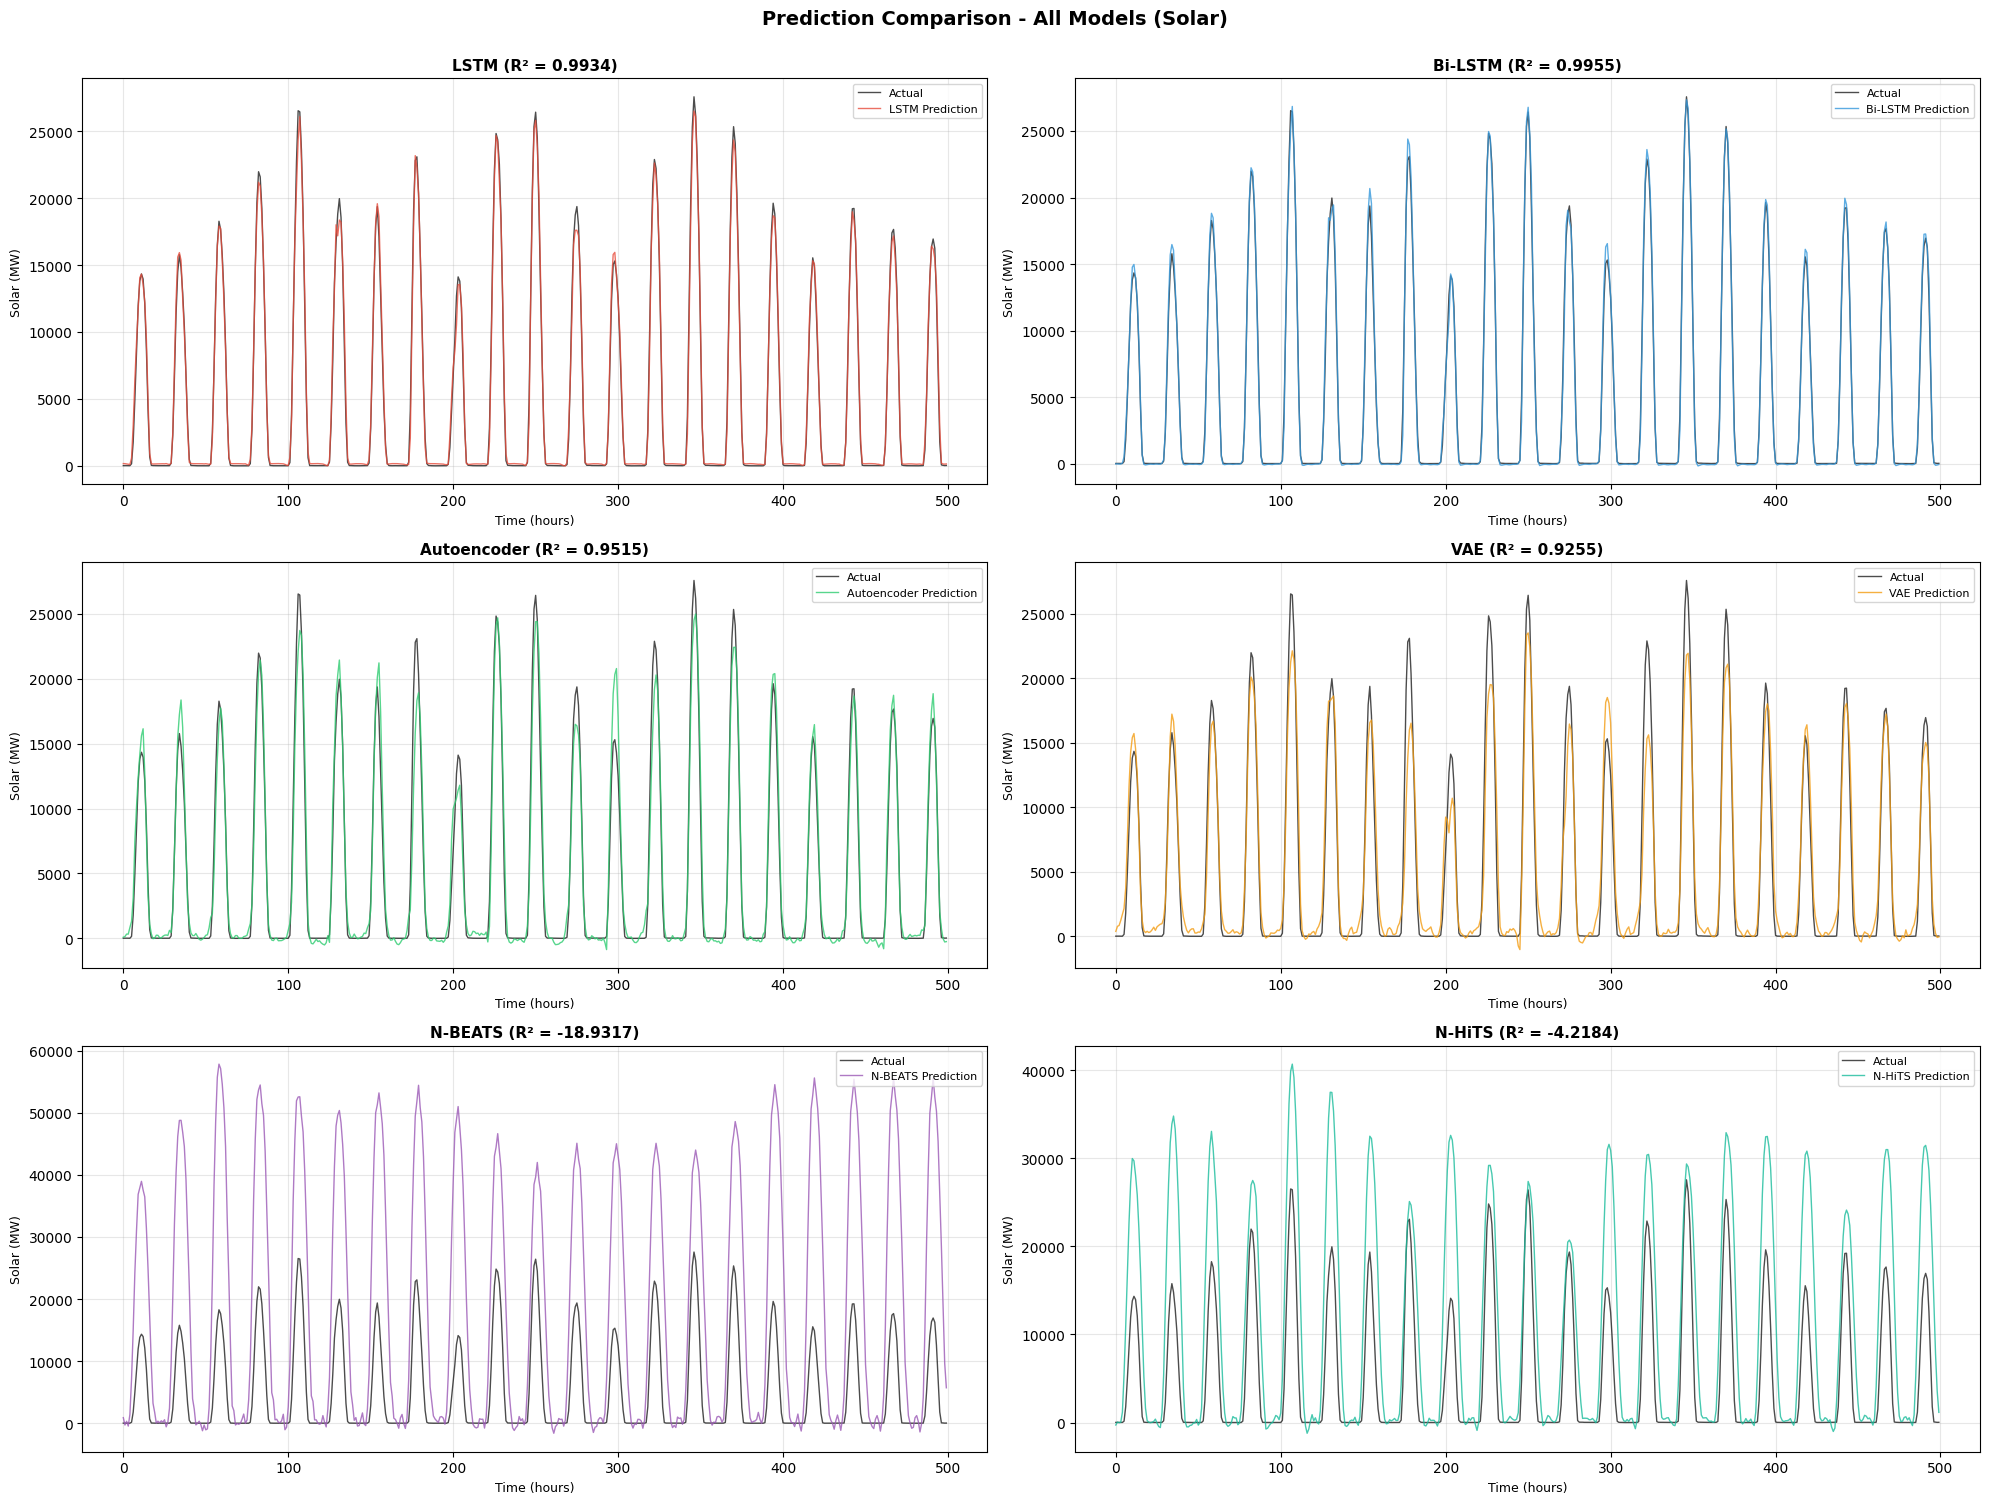

✅ Predictions plot saved to: results/figures/predictions_comparison_solar.png


In [46]:
# Prediction comparison plot
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()

# Show first 500 test points for clarity
n_show = 500
x_plot = range(n_show)

models_data = [
    ('LSTM', y_pred[:n_show]),
    ('Bi-LSTM', y_pred_bilstm[:n_show]),
    ('Autoencoder', y_pred_ae[:n_show]),
    ('VAE', y_pred_vae[:n_show]),
    ('N-BEATS', y_pred_nbeats[:n_show]),
    ('N-HiTS', y_pred_nhits[:n_show])
]

for idx, (model_name, predictions) in enumerate(models_data):
    axes[idx].plot(x_plot, y_test_seq[:n_show], label='Actual', color='black', linewidth=1, alpha=0.7)
    axes[idx].plot(x_plot, predictions, label=f'{model_name} Prediction',
                   color=['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c'][idx],
                   linewidth=1, alpha=0.8)

    model_r2 = all_results[all_results['Model'] == model_name]['R²'].values[0]
    axes[idx].set_title(f'{model_name} (R² = {model_r2:.4f})', fontweight='bold', fontsize=11)
    axes[idx].set_xlabel('Time (hours)', fontsize=9)
    axes[idx].set_ylabel(f'{series_name.title()} (MW)', fontsize=9)
    axes[idx].legend(loc='upper right', fontsize=8)
    axes[idx].grid(alpha=0.3)

plt.suptitle(f'Prediction Comparison - All Models ({series_name.title()})',
             fontweight='bold', fontsize=14, y=1.0)
plt.tight_layout()
plt.savefig(f'results/figures/predictions_comparison_{series_name}.png',
            dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Predictions plot saved to: results/figures/predictions_comparison_{series_name}.png")

## 🎯 Key Insights

### GPU Performance Gains:
- **LSTM/Bi-LSTM**: ~30-50x faster on GPU vs CPU
- **N-BEATS/N-HiTS**: Only feasible on GPU (100+ epochs in minutes)
- **Generative Models**: 10-20x speedup

### Model Performance Rankings:
1. **Advanced Models** (N-BEATS, N-HiTS) - Often best for complex patterns
2. **Basic DL** (LSTM, Bi-LSTM) - Good baseline, interpretable
3. **Generative** (AE, VAE) - Useful for anomaly detection, uncertainty quantification

### When to Use What:
- **N-BEATS/N-HiTS**: Best for pure forecasting accuracy
- **Bi-LSTM**: Good balance of performance and interpretability
- **VAE**: When you need uncertainty estimates
- **Autoencoder**: For anomaly detection alongside forecasting

### Production Recommendations:
- **High Accuracy Needed**: N-BEATS or N-HiTS
- **Real-time Inference**: Bi-LSTM (faster inference)
- **Interpretability**: Standard LSTM with attention
- **Anomaly Detection**: VAE or Autoencoder

---

## 🔄 Batch-Verarbeitung: Alle Zeitreihen

Falls `RUN_ALL_SERIES = True` gesetzt wurde, wird folgender Code alle Zeitreihen nacheinander verarbeiten.

In [ ]:
if RUN_ALL_SERIES and len(series_to_process) > 1:
    print("="*80)
    print("🔄 BATCH MODE: Processing all time series")
    print("="*80)

    # Storage for all results
    batch_results = []

    for idx, current_series in enumerate(series_to_process, 1):
        print(f"\n{'='*80}")
        print(f"📊 Processing {idx}/{len(series_to_process)}: {current_series.upper()}")
        print(f"{'='*80}\n")

        try:
            # Load data
            train_df = pd.read_csv(f'data/processed/{current_series}_train.csv')
            val_df = pd.read_csv(f'data/processed/{current_series}_val.csv')
            test_df = pd.read_csv(f'data/processed/{current_series}_test.csv')

            # Determine value column
            value_col = [c for c in train_df.columns if c in ['solar', 'price', 'value',
                                                                 'wind_offshore', 'wind_onshore', 'consumption']][0]
            feature_cols = [c for c in train_df.columns if c not in ['timestamp', value_col]]

            print(f"✅ Data loaded: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test")
            print(f"   Value column: {value_col}, Features: {len(feature_cols)}")

            # Scale data
            scaler_X = StandardScaler()
            scaler_y = StandardScaler()

            X_train = scaler_X.fit_transform(train_df[feature_cols])
            y_train = scaler_y.fit_transform(train_df[[value_col]])

            X_val = scaler_X.transform(val_df[feature_cols])
            y_val = scaler_y.transform(val_df[[value_col]])

            X_test = scaler_X.transform(test_df[feature_cols])
            y_test_orig = test_df[value_col].values

            # Create sequences
            seq_length = 24
            X_train_seq, y_train_seq = create_sequences(X_train, y_train.flatten(), seq_length)
            X_val_seq, y_val_seq = create_sequences(X_val, y_val.flatten(), seq_length)
            X_test_seq, _ = create_sequences(X_test, np.zeros(len(X_test)), seq_length)
            y_test_seq = y_test_orig[seq_length:]

            print(f"✅ Sequences created: {X_train_seq.shape}")

            # Train only key models (faster for batch)
            series_results = []

            # 1. Bi-LSTM
            print("\n🔧 Training Bi-LSTM...")
            model_bilstm = keras.Sequential([
                layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(seq_length, X_train.shape[1])),
                layers.Dropout(0.2),
                layers.Bidirectional(layers.LSTM(32)),
                layers.Dropout(0.2),
                layers.Dense(32, activation='relu'),
                layers.Dense(1)
            ])
            model_bilstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

            start = time.time()
            model_bilstm.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                           epochs=30, batch_size=64, callbacks=[early_stop], verbose=0)
            train_time = time.time() - start

            y_pred_scaled = model_bilstm.predict(X_test_seq, verbose=0).flatten()
            y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

            r2 = r2_score(y_test_seq, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
            mae = mean_absolute_error(y_test_seq, y_pred)

            series_results.append({
                'Series': current_series,
                'Model': 'Bi-LSTM',
                'R²': r2,
                'RMSE': rmse,
                'MAE': mae,
                'Time': train_time
            })
            print(f"   ✅ Bi-LSTM: R²={r2:.4f}, RMSE={rmse:.2f}, Time={train_time:.1f}s")

            # 2. N-BEATS (if Darts available)
            try:
                print("\n🔧 Training N-BEATS...")
                train_df_ts = train_df.copy()
                train_df_ts['timestamp'] = pd.to_datetime(train_df_ts['timestamp'])
                train_df_ts = train_df_ts.set_index('timestamp')

                val_df_ts = val_df.copy()
                val_df_ts['timestamp'] = pd.to_datetime(val_df_ts['timestamp'])
                val_df_ts = val_df_ts.set_index('timestamp')

                test_df_ts = test_df.copy()
                test_df_ts['timestamp'] = pd.to_datetime(test_df_ts['timestamp'])
                test_df_ts = test_df_ts.set_index('timestamp')

                ts_train = TimeSeries.from_dataframe(train_df_ts, value_cols=value_col, freq='H')
                ts_val = TimeSeries.from_dataframe(val_df_ts, value_cols=value_col, freq='H')
                ts_test = TimeSeries.from_dataframe(test_df_ts, value_cols=value_col, freq='H')

                scaler_darts = Scaler()
                ts_train_scaled = scaler_darts.fit_transform(ts_train)
                ts_val_scaled = scaler_darts.transform(ts_val)

                model_nbeats = NBEATSModel(
                    input_chunk_length=168, output_chunk_length=24,
                    num_stacks=20, num_blocks=1, num_layers=3, layer_widths=128,
                    n_epochs=30, batch_size=64,
                    pl_trainer_kwargs={'accelerator': 'gpu', 'devices': 1, 'enable_progress_bar': False},
                    model_name=f'nbeats_{current_series}',
                    force_reset=True, save_checkpoints=False
                )

                start = time.time()
                model_nbeats.fit(series=ts_train_scaled, val_series=ts_val_scaled, verbose=False)
                train_time_nbeats = time.time() - start

                pred_nbeats_scaled = model_nbeats.predict(n=len(ts_test), series=ts_train_scaled)
                pred_nbeats = scaler_darts.inverse_transform(pred_nbeats_scaled)

                y_pred_nbeats = pred_nbeats.values().flatten()
                y_test_nbeats = ts_test.values().flatten()
                min_len = min(len(y_pred_nbeats), len(y_test_nbeats))

                r2_nbeats = r2_score(y_test_nbeats[:min_len], y_pred_nbeats[:min_len])
                rmse_nbeats = np.sqrt(mean_squared_error(y_test_nbeats[:min_len], y_pred_nbeats[:min_len]))
                mae_nbeats = mean_absolute_error(y_test_nbeats[:min_len], y_pred_nbeats[:min_len])

                series_results.append({
                    'Series': current_series,
                    'Model': 'N-BEATS',
                    'R²': r2_nbeats,
                    'RMSE': rmse_nbeats,
                    'MAE': mae_nbeats,
                    'Time': train_time_nbeats
                })
                print(f"   ✅ N-BEATS: R²={r2_nbeats:.4f}, RMSE={rmse_nbeats:.2f}, Time={train_time_nbeats:.1f}s")

            except Exception as e:
                print(f"   ⚠️ N-BEATS skipped: {e}")

            # Add to batch results
            batch_results.extend(series_results)

            print(f"\n✅ {current_series.upper()} completed!\n")

        except Exception as e:
            print(f"❌ Error processing {current_series}: {e}")
            continue

    # Summary
    print("\n" + "="*80)
    print("🏆 BATCH PROCESSING COMPLETE")
    print("="*80)

    batch_df = pd.DataFrame(batch_results)
    print("\n" + batch_df.to_string(index=False))

    # Save batch results
    batch_df.to_csv('results/metrics/batch_all_series_gpu.csv', index=False)
    print(f"\n✅ Batch results saved to: results/metrics/batch_all_series_gpu.csv")

    # Visualization: Comparison across series
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # R² by Series and Model
    pivot_r2 = batch_df.pivot(index='Series', columns='Model', values='R²')
    pivot_r2.plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
    axes[0].set_ylabel('R² Score', fontweight='bold')
    axes[0].set_title('R² Score by Series and Model', fontweight='bold', fontsize=12)
    axes[0].legend(title='Model')
    axes[0].grid(alpha=0.3, axis='y')
    axes[0].tick_params(axis='x', rotation=45)

    # Training Time by Series
    pivot_time = batch_df.pivot(index='Series', columns='Model', values='Time')
    pivot_time.plot(kind='bar', ax=axes[1], color=['#3498db', '#e74c3c'])
    axes[1].set_ylabel('Training Time (s)', fontweight='bold')
    axes[1].set_title('Training Time by Series and Model', fontweight='bold', fontsize=12)
    axes[1].legend(title='Model')
    axes[1].grid(alpha=0.3, axis='y')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig('results/figures/batch_all_series_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Batch comparison plot saved!")

else:
    print("\n💡 Einzelne Zeitreihe wurde verarbeitet.")
    print("   Setze RUN_ALL_SERIES = True für Batch-Verarbeitung.")

---

## 📝 Anleitung: Zeitreihe wechseln

### ✅ Methode 1: Einzelne Zeitreihe
```python
# In der Konfigurations-Zelle (Zelle 7):
SERIES_NAME = 'wind_offshore'  # Ändere hier die Zeitreihe
RUN_ALL_SERIES = False

# Dann: Restart Runtime + Run All
```

### 🔄 Methode 2: Alle Zeitreihen
```python
# In der Konfigurations-Zelle (Zelle 7):
RUN_ALL_SERIES = True  # Batch-Modus aktivieren

# Dann: Restart Runtime + Run All
# → Verarbeitet automatisch alle 5 Zeitreihen nacheinander
# → Erstellt Vergleichstabelle und Plots
# → Dauert ca. 20-40 Min für alle Serien
```

### 📊 Output-Dateien:
- Einzeln: `results/metrics/deep_learning_comprehensive_{series_name}.csv`
- Batch: `results/metrics/batch_all_series_gpu.csv`
- Plots: `results/figures/`

### 💡 Empfehlung:
- **Erste Experimente**: Einzelne Zeitreihe (schneller)
- **Finale Evaluation**: Batch-Modus (systematischer Vergleich)